# Image Retrieval

Представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Возьмем VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них NearestNeighbors `(sklearn.neighbors.NearestNeighbors)`, например, с `n_neighbors=5`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного NearestNeighbors ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

# Загрузка данных

In [ ]:
import os
import numpy as np
import pandas as pd
import random
from IPython.display import clear_output

from torch.autograd import Variable
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data_utils
from torch.utils.data import DataLoader


import skimage.io
from skimage.transform import resize
import pickle

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer

from time import time
from tqdm import tqdm
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2)
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

!pip install matplotlib --upgrade
print('matplotlib: {}'.format(matplotlib.__version__))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
matplotlib: 3.6.2


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
DATA_DIR = '/content/gdrive/MyDrive/autoencoders/'

In [ ]:
!pip freeze > requirements.txt

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

set_seed(0)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    DEVICE = torch.device("cpu")
else:
    print('CUDA is available!  Training on GPU ...')
    DEVICE = torch.device("cuda")

CUDA is available!  Training on GPU ...


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values).astype('float32')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
# from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


Выведем таблицу атрибутов изображений

In [ ]:
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
torch.cuda.empty_cache()
!nvidia-smi

cuda
Mon Dec 19 07:50:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [ ]:
data, attrs = fetch_dataset()

X_train, X_val, atts_train, attrs_val = train_test_split(data, attrs, train_size=0.8,
                                                        shuffle=True, random_state=1
                                                        )

In [ ]:
train_loader = DataLoader(np.rollaxis(X_train, 3, 1), batch_size=256,
                          shuffle=True, drop_last=True
                          )
val_loader = DataLoader(np.rollaxis(X_val, 3, 1), batch_size=256,
                          shuffle=False, drop_last=True
                        )

Напишем архитектуру:

In [ ]:
features = 256

class VAE_fetch(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            # s1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding = 1, padding_mode='replicate'),
            nn.ReLU(),
            # 2
            nn.MaxPool2d(kernel_size=2), # 64 -> 32
            # 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1), # 32 -> 16
            nn.ReLU(),

            nn.Flatten(),

            nn.Linear(in_features=16*16*64, out_features=16*64),
            nn.ReLU(),

            nn.Linear(in_features=16*64, out_features=features*2)
          )

        self.decoder = nn.Sequential(

            nn.Linear(in_features=features, out_features=16*64),
            nn.ReLU(),

            nn.Linear(in_features=16*64, out_features=16*16*64),
            nn.ReLU(),

            nn.Unflatten(1, torch.Size([64, 16, 16])),
            # 4
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1), # 16 -> 32
            nn.ReLU(),
            # 5
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1), # 32 -> 64
            nn.ReLU(),
            # 6
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=1)
        )


    def encode(self, x):
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:

            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)

        else:
            sample = mu

        return sample

    def decode(self, z, eps=1e-7):
        x = self.decoder(z)
        reconstruction = torch.clamp(x.sigmoid(), min=eps, max=1-eps)

        return reconstruction

    def sample(self, z, eps=1e-7):
        generated = self.decoder(z)
        generated = torch.clamp(torch.sigmoid(generated), 0+eps, 1-eps)
        return generated

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

In [ ]:
import torchsummary
vaef = VAE_fetch().to(DEVICE)
torchsummary.summary(vaef, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
         MaxPool2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 16, 16]          32,832
              ReLU-5           [-1, 64, 16, 16]               0
           Flatten-6                [-1, 16384]               0
            Linear-7                 [-1, 1024]      16,778,240
              ReLU-8                 [-1, 1024]               0
            Linear-9                  [-1, 512]         524,800
           Linear-10                 [-1, 1024]         263,168
             ReLU-11                 [-1, 1024]               0
           Linear-12                [-1, 16384]      16,793,600
             ReLU-13                [-1, 16384]               0
        Unflatten-14           [-1, 64,

Лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем кросс-энтропию.

Зададим функцию потерь:

In [ ]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss / mu.shape[0]

def log_likelihood(x, reconstruction):
    batch = x.shape[0]
    x = x.view(-1)
    reconstruction = reconstruction.view(-1)
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x) / batch

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

Функция обучения:

In [ ]:
def train_model(train_loader, val_loader, model, model_name, epochs, criterion,
                optimizer, scheduler):

    best_loss = 77777
    since = time()

    # loss per batch
    train_losses = []
    test_losses = []

    for epoch in tqdm(range(epochs)):
        set_seed(0 + epoch)
        # train
        model.train()
        train_losses_per_epoch = []

        for x_batch in train_loader:
          x_batch = x_batch.to(DEVICE)
          mu, logsigma, reconstruction = model(x_batch)
          loss = criterion(x_batch, mu, logsigma, reconstruction)

          loss.backward()
          optimizer.step()

          train_losses_per_epoch.append(loss.detach().cpu().item())

          optimizer.zero_grad()

        train_losses.append(np.mean(train_losses_per_epoch))

        scheduler.step()
        # test
        model.eval()
        test_losses_per_epoch = []

        with torch.no_grad():
          for x_batch in val_loader:
            x_batch = x_batch.to(DEVICE)
            mu, logsigma, reconstruction = model(x_batch)
            loss = criterion(x_batch, mu, logsigma, reconstruction)

            test_losses_per_epoch.append(loss.detach().cpu().item())

        test_losses.append(np.mean(test_losses_per_epoch))
        # save best model
        if best_loss > test_losses[-1]:
            best_loss = test_losses[-1].round(2)
            best_t_loss = train_losses[-1].round(2)
            torch.save(model.state_dict(), os.path.join(DATA_DIR, 'best_' + model_name + '.pth'))
            best_epoch = epoch + 1
            best_time = round(time() - since)
        # save current model
        torch.save(model.state_dict(), os.path.join(DATA_DIR, 'last_' + model_name + '.pth'))
        # Visualize
        clear_output(wait=True)

        truth = x_batch.cpu().numpy()
        reconst = reconstruction.cpu().numpy()

        plt.figure(figsize=(15, 9))

        for k in range(5):
            plt.subplot(4, 5, k + 1)
            plt.imshow(np.rollaxis(truth[k], 0, 3))
            plt.axis("off")
            plt.title('Input')

            plt.subplot(4, 5, k + 6)
            plt.imshow(np.rollaxis(reconst[k], 0, 3))
            plt.axis("off")
            plt.title('Output')

        plt.subplot(2,1,2)
        plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="train loss")
        plt.plot(np.arange(1, len(test_losses) + 1), test_losses, label="val loss")
        best_ep = np.argmin(test_losses) + 1
        plt.axvline(best_ep, color='r', label="best epoch")
        plt.legend(loc='upper right')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.title(model_name + " loss")

        plt.suptitle(f'{epoch + 1} / {epochs} - train loss: {train_losses[-1]:.4f} - val loss: {test_losses[-1]:.4f}',
                     fontsize=18)

        plt.show();

    print(f'\nYEAH! Best time {best_time}, best epoch {best_epoch}, best val loss {best_loss}, best train loss {best_t_loss}')
    # load best weights
    model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_' + model_name + '.pth')))

    return model

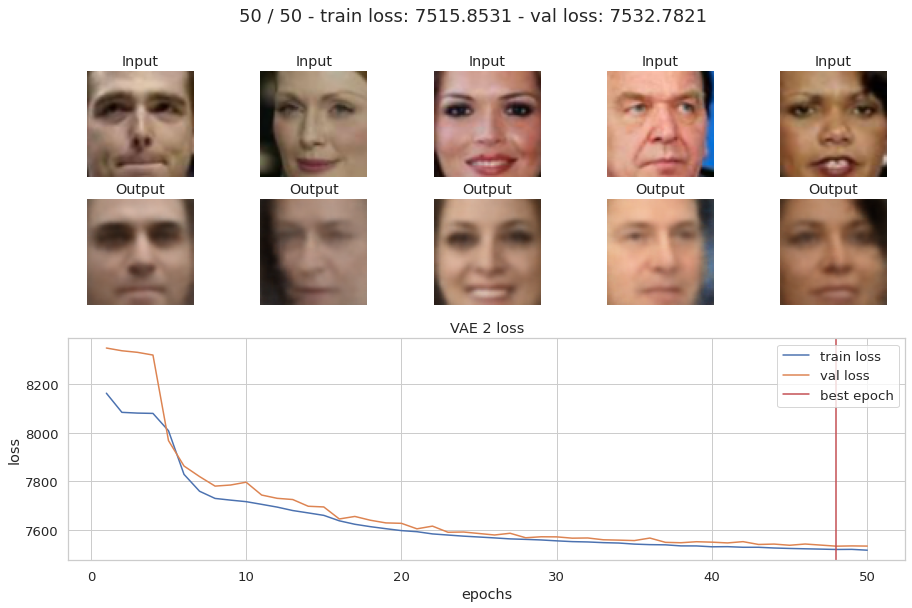


YEAH! Best time 282, best epoch 48, best val loss 7532.43, best train loss 7518.8


In [ ]:
torch.cuda.empty_cache()
criterion = loss_vae
vaef = VAE_fetch().to(DEVICE)
optimizer =  optim.AdamW(params = vaef.parameters())
model_name = 'VAE 2'
epochs = 50
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
vaef = train_model(train_loader, val_loader, vaef, model_name, epochs, criterion, optimizer, scheduler)

Загрузим модель:

In [ ]:
vaef = VAE_fetch().to(DEVICE)
vaef.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_VAE 2.pth')))

<All keys matched successfully>

Создадим новый даталоадер без перемешивания и с сохранением последнего некомплектного батча, чтобы потом найти по индексам "ближайших соседей".

In [ ]:
t_loader = DataLoader(np.rollaxis(X_train, 3, 1), batch_size=512,
                          shuffle=False, drop_last=False)

# Получим латентные представления всех лиц тренировочного датасета

codes = np.zeros((1,features))

with torch.no_grad():
  vaef.eval()
  for inputs in train_loader:
    inputs = inputs.to(DEVICE)
    latent, _ = vaef.encode(inputs)
    codes = np.concatenate((codes, latent.cpu().numpy()))

codes = np.delete(codes, 0, axis=0)

print(f'Размеры полученных латентных векторов {codes.shape}.')

# Сохраним codes
with open(os.path.join(DATA_DIR, 'codes_latent.pickle'), 'wb') as f:
    pickle.dump(codes, f)

Размеры полученных латентных векторов (10496, 256).


Берём NearestNeighbors

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5, radius=1, leaf_size=5).fit(codes)

with open(os.path.join(DATA_DIR, 'neighbors_vaef2.pickle'), 'wb') as f:
    pickle.dump(neigh, f)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  t_image = torch.FloatTensor(np.rollaxis(image[np.newaxis], 3, 1)).to(DEVICE)
  vaef.eval()
  with torch.no_grad():
    code, _ = vaef.encode(t_image)

  (distances,),(idx,) = neigh.kneighbors(code.cpu().numpy(), n_neighbors=n_neighbors)

  t_codes = torch.cuda.FloatTensor(codes[idx])

  vaef.eval()
  with torch.no_grad():
    reconst = vaef.decode(t_codes)

  return distances, reconst.cpu().numpy()

In [ ]:
def show_similar(image, n_neighbors=5):
  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances, neighbors = get_similar(image,n_neighbors=n_neighbors)

    plt.figure(figsize=[15,9])
    plt.subplot(2, 5, 1)
    plt.axis("off")
    plt.imshow(image)
    plt.title("Original image")

    for k in range(n_neighbors):
        plt.subplot(2, np.ceil(n_neighbors/2), k + 2)
        plt.axis("off")
        plt.imshow(neighbors[k].transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[k])

    plt.show()

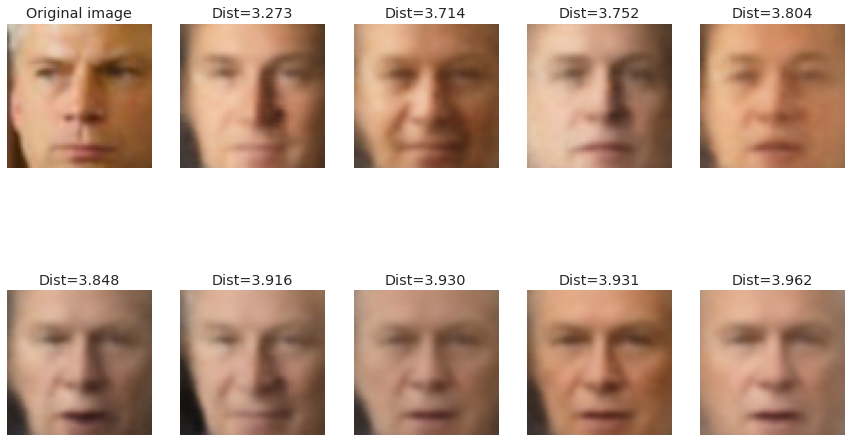

In [ ]:
show_similar(X_val[1], n_neighbors=9)